In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [6]:
batch_size = 12
epochs     = 100  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 5
gamma      = 0.5
model_use  = "box_gan" # "unity" "histogram" "box_gan"
save_name = "box_gan_all"
n_class = 21

## Define path, directory trainning environment

In [7]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
val_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/real")
if not os.path.exists(val_dir):
    print("Validation Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/mm_fcn/models", save_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/mm_fcn/scores", save_name)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 1.7407066822052002


Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [8]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w
brand_class = ['3m', 'andes', 'cocacola', 'crayola', 'folgers','heineken','hunts','kellogg','kleenex',\
               'kotex','libava','macadamia','milo','mm','pocky','raisins','stax','swissmiss','vanish','viva']
class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        self.phase = phase
        if self.phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]
        label_name = self.data.iloc[idx, 1]
        if self.phase == 'train':
            img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
            label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
            #print(os.path.join(data_dir, img_name))
        else:
            img        = cv2.imread(os.path.join(val_dir, img_name),cv2.IMREAD_UNCHANGED)
            label      = cv2.imread(os.path.join(val_dir, label_name), cv2.IMREAD_GRAYSCALE)
            #print(os.path.join(val_dir, label_name))
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        '''for i in range(n_class - 1):
            if brand_class[i] in img_name:
                target[i+1][label != 0] = 1
                label[label != 0] = i+1
                #print(brand_class[i], img_name,label_name)'''
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [9]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train_with_box_all.csv")
val_file   = os.path.join(val_dir, "test.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)

dataiter = iter(val_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Train

In [10]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 1 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [11]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('epoch:'+ str(epoch) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('epoch:'+ str(epoch) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('epoch:'+ str(epoch) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [ ]:
train()

epoch1, iter0, loss: 0.7099413275718689
epoch1, iter10, loss: 0.6947981715202332
epoch1, iter20, loss: 0.6899296641349792
epoch1, iter30, loss: 0.6866329908370972
epoch1, iter40, loss: 0.6845737099647522
epoch1, iter50, loss: 0.6794306039810181
epoch1, iter60, loss: 0.6772987246513367
epoch1, iter70, loss: 0.675286591053009
epoch1, iter80, loss: 0.6715834736824036
epoch1, iter90, loss: 0.6681494116783142
epoch1, iter100, loss: 0.6663878560066223
epoch1, iter110, loss: 0.6673083305358887
epoch1, iter120, loss: 0.6639223694801331
epoch1, iter130, loss: 0.6622219085693359
epoch1, iter140, loss: 0.6630954146385193
epoch1, iter150, loss: 0.6575855016708374
epoch1, iter160, loss: 0.654667854309082
epoch1, iter170, loss: 0.6558808088302612
epoch1, iter180, loss: 0.6523875594139099
epoch1, iter190, loss: 0.6488329768180847
epoch1, iter200, loss: 0.6494695544242859
epoch1, iter210, loss: 0.6433656811714172
epoch1, iter220, loss: 0.6463812589645386
epoch1, iter230, loss: 0.6416429877281189
epoch

epoch1, iter1930, loss: 0.1761278361082077
epoch1, iter1940, loss: 0.1727682501077652
epoch1, iter1950, loss: 0.17116141319274902
epoch1, iter1960, loss: 0.16846677660942078
epoch1, iter1970, loss: 0.16719357669353485
epoch1, iter1980, loss: 0.16395767033100128
epoch1, iter1990, loss: 0.16383567452430725
epoch1, iter2000, loss: 0.16172492504119873
epoch1, iter2010, loss: 0.1578986942768097
epoch1, iter2020, loss: 0.15689104795455933
epoch1, iter2030, loss: 0.1559213548898697
epoch1, iter2040, loss: 0.15431907773017883
epoch1, iter2050, loss: 0.15110287070274353
epoch1, iter2060, loss: 0.14913220703601837
epoch1, iter2070, loss: 0.14819051325321198
epoch1, iter2080, loss: 0.14559508860111237
epoch1, iter2090, loss: 0.14421676099300385
epoch1, iter2100, loss: 0.1420230120420456
epoch1, iter2110, loss: 0.140489399433136
epoch1, iter2120, loss: 0.13910430669784546
epoch1, iter2130, loss: 0.1355663686990738
epoch1, iter2140, loss: 0.13478049635887146
epoch1, iter2150, loss: 0.13406012952327

epoch1, iter3790, loss: 0.018807487562298775
epoch1, iter3800, loss: 0.020164771005511284
epoch1, iter3810, loss: 0.01881396397948265
epoch1, iter3820, loss: 0.01876487210392952
epoch1, iter3830, loss: 0.017723670229315758
epoch1, iter3840, loss: 0.021510718390345573
epoch1, iter3850, loss: 0.0136612793430686
epoch1, iter3860, loss: 0.01711535081267357
epoch1, iter3870, loss: 0.017663173377513885
epoch1, iter3880, loss: 0.01467171497642994
epoch1, iter3890, loss: 0.013756598345935345
epoch1, iter3900, loss: 0.017598116770386696
epoch1, iter3910, loss: 0.016458339989185333
epoch1, iter3920, loss: 0.016960907727479935
epoch1, iter3930, loss: 0.020517028868198395
epoch1, iter3940, loss: 0.015081881545484066
epoch1, iter3950, loss: 0.016546150669455528
epoch1, iter3960, loss: 0.015200216323137283
epoch1, iter3970, loss: 0.015751872211694717
epoch1, iter3980, loss: 0.016204072162508965
epoch1, iter3990, loss: 0.011768613941967487
epoch1, iter4000, loss: 0.01554827019572258
epoch1, iter4010,

epoch1, iter5620, loss: 0.004497434478253126
epoch1, iter5630, loss: 0.0032178773544728756
epoch1, iter5640, loss: 0.004927089437842369
epoch1, iter5650, loss: 0.004894838202744722
epoch1, iter5660, loss: 0.005720322486013174
epoch1, iter5670, loss: 0.0037734941579401493
epoch1, iter5680, loss: 0.002967734355479479
epoch1, iter5690, loss: 0.004986134823411703
epoch1, iter5700, loss: 0.003145829541608691
epoch1, iter5710, loss: 0.0030104806646704674
epoch1, iter5720, loss: 0.014244220219552517
epoch1, iter5730, loss: 0.006538375746458769
epoch1, iter5740, loss: 0.005266054533421993
epoch1, iter5750, loss: 0.004068025387823582
epoch1, iter5760, loss: 0.004077380057424307
epoch1, iter5770, loss: 0.001910426071844995
epoch1, iter5780, loss: 0.0034133601002395153
epoch1, iter5790, loss: 0.0024126050993800163
epoch1, iter5800, loss: 0.005516970530152321
epoch1, iter5810, loss: 0.007099607959389687
epoch1, iter5820, loss: 0.002056592144072056
epoch1, iter5830, loss: 0.004451621789485216
epoch

epoch2, iter1310, loss: 0.0021453010849654675
epoch2, iter1320, loss: 0.0013305210741236806
epoch2, iter1330, loss: 0.0037319583352655172
epoch2, iter1340, loss: 0.0019235544605180621
epoch2, iter1350, loss: 0.002166525460779667
epoch2, iter1360, loss: 0.001061692601069808
epoch2, iter1370, loss: 0.005284357815980911
epoch2, iter1380, loss: 0.002139623509719968
epoch2, iter1390, loss: 0.00132693478371948
epoch2, iter1400, loss: 0.004844656214118004
epoch2, iter1410, loss: 0.0008881182875484228
epoch2, iter1420, loss: 0.0014830523869022727
epoch2, iter1430, loss: 0.0024349987506866455
epoch2, iter1440, loss: 0.0011000025551766157
epoch2, iter1450, loss: 0.0023525282740592957
epoch2, iter1460, loss: 0.0012370847398415208
epoch2, iter1470, loss: 0.0020283025223761797
epoch2, iter1480, loss: 0.0011369509156793356
epoch2, iter1490, loss: 0.0017370367422699928
epoch2, iter1500, loss: 0.0012298410292714834
epoch2, iter1510, loss: 0.0028742251452058554
epoch2, iter1520, loss: 0.001675243722274

epoch2, iter3110, loss: 0.0013989385915920138
epoch2, iter3120, loss: 0.000880424864590168
epoch2, iter3130, loss: 0.0014059935929253697
epoch2, iter3140, loss: 0.0006034655962139368
epoch2, iter3150, loss: 0.0005583266029134393
epoch2, iter3160, loss: 0.0005682442570105195
epoch2, iter3170, loss: 0.01991313323378563
epoch2, iter3180, loss: 0.0005886730505153537
epoch2, iter3190, loss: 0.0013919419143348932
epoch2, iter3200, loss: 0.0018219236517325044
epoch2, iter3210, loss: 0.0007790080853737891
epoch2, iter3220, loss: 0.0010157638462260365
epoch2, iter3230, loss: 0.0005931142950430512
epoch2, iter3240, loss: 0.0020844205282628536
epoch2, iter3250, loss: 0.0005414985935203731
epoch2, iter3260, loss: 0.0012015443062409759
epoch2, iter3270, loss: 0.004078597761690617
epoch2, iter3280, loss: 0.0024972849059849977
epoch2, iter3290, loss: 0.0016911948332563043
epoch2, iter3300, loss: 0.0005283362115733325
epoch2, iter3310, loss: 0.0008604770409874618
epoch2, iter3320, loss: 0.001200965256

epoch2, iter4900, loss: 0.0006107846857048571
epoch2, iter4910, loss: 0.0008223034092225134
epoch2, iter4920, loss: 0.0005546131869778037
epoch2, iter4930, loss: 0.0007281661382876337
epoch2, iter4940, loss: 0.0005000745877623558
epoch2, iter4950, loss: 0.00045691506238654256
epoch2, iter4960, loss: 0.00025530962739139795
epoch2, iter4970, loss: 0.0006806041928939521
epoch2, iter4980, loss: 0.00036949911736883223
epoch2, iter4990, loss: 0.0004104191903024912
epoch2, iter5000, loss: 0.00043086305959150195
epoch2, iter5010, loss: 0.0006187367835082114
epoch2, iter5020, loss: 0.000518707325682044
epoch2, iter5030, loss: 0.0004477972397580743
epoch2, iter5040, loss: 0.0102226622402668
epoch2, iter5050, loss: 0.004819404799491167
epoch2, iter5060, loss: 0.0026409649290144444
epoch2, iter5070, loss: 0.0004783200565725565
epoch2, iter5080, loss: 0.0010859993053600192
epoch2, iter5090, loss: 0.0013584658736363053
epoch2, iter5100, loss: 0.0008660502498969436
epoch2, iter5110, loss: 0.000453591

epoch3, iter610, loss: 0.00383632886223495
epoch3, iter620, loss: 0.0018812533235177398
epoch3, iter630, loss: 0.0012731371680274606
epoch3, iter640, loss: 0.0010303150629624724
epoch3, iter650, loss: 0.0003810670168604702
epoch3, iter660, loss: 0.0005445120623335242
epoch3, iter670, loss: 0.00027228600811213255
epoch3, iter680, loss: 0.0004402502963785082
epoch3, iter690, loss: 0.0003018256102222949
epoch3, iter700, loss: 0.00030371363391168416
epoch3, iter710, loss: 0.0003456435224507004
epoch3, iter720, loss: 0.0002551962388679385
epoch3, iter730, loss: 0.0038587453309446573
epoch3, iter740, loss: 0.0004904614179395139
epoch3, iter750, loss: 0.0006479715812020004
epoch3, iter760, loss: 0.0005236169090494514
epoch3, iter770, loss: 0.00020014452456962317
epoch3, iter780, loss: 0.0003072463150601834
epoch3, iter790, loss: 0.00044759988668374717
epoch3, iter800, loss: 0.0007333099492825568
epoch3, iter810, loss: 0.0004327382193878293
epoch3, iter820, loss: 0.00044982574763707817
epoch3,

epoch3, iter2400, loss: 0.0005397144705057144
epoch3, iter2410, loss: 0.0010569266742095351
epoch3, iter2420, loss: 0.0003662659437395632
epoch3, iter2430, loss: 0.0002958327531814575
epoch3, iter2440, loss: 0.00031848292564973235
epoch3, iter2450, loss: 0.0002961820864584297
epoch3, iter2460, loss: 0.00029845666722394526
epoch3, iter2470, loss: 0.0002380739024374634
epoch3, iter2480, loss: 0.0002277653111377731
epoch3, iter2490, loss: 0.00023689467343501747
epoch3, iter2500, loss: 0.0005430490709841251
epoch3, iter2510, loss: 0.001193672651425004
epoch3, iter2520, loss: 0.0004956015618517995
epoch3, iter2530, loss: 0.0008261882467195392
epoch3, iter2540, loss: 0.0003290187451057136
epoch3, iter2550, loss: 0.00047595161595381796
epoch3, iter2560, loss: 0.00026188703486695886
epoch3, iter2570, loss: 0.00028894655406475067
epoch3, iter2580, loss: 0.0002969681518152356
epoch3, iter2590, loss: 0.0004826691292691976
epoch3, iter2600, loss: 0.0003727130824699998
epoch3, iter2610, loss: 0.000

epoch3, iter4180, loss: 0.0011358328629285097
epoch3, iter4190, loss: 0.0001960969384526834
epoch3, iter4200, loss: 0.0003396215324755758
epoch3, iter4210, loss: 0.0004995895433239639
epoch3, iter4220, loss: 0.0003572964633349329
epoch3, iter4230, loss: 0.0003029957879334688
epoch3, iter4240, loss: 0.00017942114209290594
epoch3, iter4250, loss: 0.0003657608467619866
epoch3, iter4260, loss: 0.00037496109143830836
epoch3, iter4270, loss: 0.003231651848182082
epoch3, iter4280, loss: 0.0017296645091846585
epoch3, iter4290, loss: 0.001629671431146562
epoch3, iter4300, loss: 0.0002974298840854317
epoch3, iter4310, loss: 0.00023451069137081504
epoch3, iter4320, loss: 0.00037433215766213834
epoch3, iter4330, loss: 0.0006477786810137331
epoch3, iter4340, loss: 0.0006659658974967897
epoch3, iter4350, loss: 0.00041192499338649213
epoch3, iter4360, loss: 0.00030832694028504193
epoch3, iter4370, loss: 0.0003511577669996768
epoch3, iter4380, loss: 0.00040363831794820726
epoch3, iter4390, loss: 0.000

epoch4, iter0, loss: 0.000386899511795491
epoch4, iter10, loss: 0.00026965897995978594
epoch4, iter20, loss: 0.0002415592025499791
epoch4, iter30, loss: 0.00020091487385798246
epoch4, iter40, loss: 0.0004185278667137027
epoch4, iter50, loss: 0.00041221300489269197
epoch4, iter60, loss: 0.00029452971648424864
epoch4, iter70, loss: 0.00046829256461933255
epoch4, iter80, loss: 0.0002945073356386274
epoch4, iter90, loss: 0.00022045850346330553
epoch4, iter100, loss: 0.00023023610992822796
epoch4, iter110, loss: 0.0011653266847133636
epoch4, iter120, loss: 0.001558193238452077
epoch4, iter130, loss: 0.0006817540270276368
epoch4, iter140, loss: 0.00030918733682483435
epoch4, iter150, loss: 0.00023066597350407392
epoch4, iter160, loss: 0.00026295825955457985
epoch4, iter170, loss: 0.00040580524364486337
epoch4, iter180, loss: 0.0006098727462813258
epoch4, iter190, loss: 0.0007560397498309612
epoch4, iter200, loss: 0.0003954838612116873
epoch4, iter210, loss: 0.00045811437303200364
epoch4, ite

epoch4, iter1800, loss: 0.00035962826223112643
epoch4, iter1810, loss: 0.00030631612753495574
epoch4, iter1820, loss: 0.00016821060853544623
epoch4, iter1830, loss: 0.00017910453607328236
epoch4, iter1840, loss: 0.00048553114174865186
epoch4, iter1850, loss: 0.0004839059547521174
epoch4, iter1860, loss: 0.004564720205962658
epoch4, iter1870, loss: 0.0014248256338760257
epoch4, iter1880, loss: 0.000359254889190197
epoch4, iter1890, loss: 0.0003580948105081916
epoch4, iter1900, loss: 0.00043095205910503864
epoch4, iter1910, loss: 0.0004216028901282698
epoch4, iter1920, loss: 0.000213142586289905
epoch4, iter1930, loss: 0.00027631345437839627
epoch4, iter1940, loss: 0.00026060076197609305
epoch4, iter1950, loss: 0.00031963075161911547
epoch4, iter1960, loss: 0.00022770510986447334
epoch4, iter1970, loss: 0.00025030539836734533
epoch4, iter1980, loss: 0.00043956667650491
epoch4, iter1990, loss: 0.00025865246425382793
epoch4, iter2000, loss: 0.00047364088823087513
epoch4, iter2010, loss: 0.

epoch4, iter3580, loss: 0.00023821766080800444
epoch4, iter3590, loss: 0.00045599014265462756
epoch4, iter3600, loss: 0.0007270075147971511
epoch4, iter3610, loss: 0.00024316099006682634
epoch4, iter3620, loss: 0.02017931081354618
epoch4, iter3630, loss: 0.0005399663932621479
epoch4, iter3640, loss: 0.0018401599954813719
epoch4, iter3650, loss: 0.0003295902570243925
epoch4, iter3660, loss: 0.0005521755665540695
epoch4, iter3670, loss: 0.0002679656317923218
epoch4, iter3680, loss: 0.0002730345877353102
epoch4, iter3690, loss: 0.0003851099463645369
epoch4, iter3700, loss: 0.00030361072276718915
epoch4, iter3710, loss: 0.0002281779161421582
epoch4, iter3720, loss: 0.00024027028121054173
epoch4, iter3730, loss: 0.00022203297703526914
epoch4, iter3740, loss: 0.0002718798932619393
epoch4, iter3750, loss: 0.00028688673046417534
epoch4, iter3760, loss: 0.0005095332162454724
epoch4, iter3770, loss: 0.0003240523219574243
epoch4, iter3780, loss: 0.0001803273771656677
epoch4, iter3790, loss: 0.000

epoch4, iter5360, loss: 0.020361702889204025
epoch4, iter5370, loss: 0.0008343583322130144
epoch4, iter5380, loss: 0.003346050390973687
epoch4, iter5390, loss: 0.000522121787071228
epoch4, iter5400, loss: 0.0004906338872388005
epoch4, iter5410, loss: 0.0002557454281486571
epoch4, iter5420, loss: 0.0004950552829541266
epoch4, iter5430, loss: 0.0002701345656532794
epoch4, iter5440, loss: 0.0006468926439993083
epoch4, iter5450, loss: 0.000273428566288203
epoch4, iter5460, loss: 0.0009783479617908597
epoch4, iter5470, loss: 0.0002498733520042151
epoch4, iter5480, loss: 0.00021690384892281145
epoch4, iter5490, loss: 0.0003360546543262899
epoch4, iter5500, loss: 0.00024137053696904331
epoch4, iter5510, loss: 0.00037109744152985513
epoch4, iter5520, loss: 0.0001700303255347535
epoch4, iter5530, loss: 0.00020020741794724017
epoch4, iter5540, loss: 0.00041823781793937087
epoch4, iter5550, loss: 0.00015924213221296668
epoch4, iter5560, loss: 0.0002008739102166146
epoch4, iter5570, loss: 0.000781

epoch5, iter1070, loss: 0.00023678361321799457
epoch5, iter1080, loss: 0.00015360188263002783
epoch5, iter1090, loss: 0.0002104175218846649
epoch5, iter1100, loss: 0.016166433691978455
epoch5, iter1110, loss: 0.001708739553578198
epoch5, iter1120, loss: 0.0006927534705027938
epoch5, iter1130, loss: 0.0003599997144192457
epoch5, iter1140, loss: 0.00024932133965194225
epoch5, iter1150, loss: 0.0003470070369075984
epoch5, iter1160, loss: 0.0002683543134480715
epoch5, iter1170, loss: 0.00020076805958524346
epoch5, iter1180, loss: 0.00019332465308252722
epoch5, iter1190, loss: 0.0003236326156184077
epoch5, iter1200, loss: 0.0002589037758298218
epoch5, iter1210, loss: 0.0002892836928367615
epoch5, iter1220, loss: 0.0002312391297891736
epoch5, iter1230, loss: 0.00023442204110324383
epoch5, iter1240, loss: 0.00025602575624361634
epoch5, iter1250, loss: 0.0009991925908252597
epoch5, iter1260, loss: 0.00020769650291185826
epoch5, iter1270, loss: 0.0002824505791068077
epoch5, iter1280, loss: 0.00

epoch5, iter2840, loss: 0.0010177689837291837
epoch5, iter2850, loss: 0.0009456477127969265
epoch5, iter2860, loss: 0.0002124644088326022
epoch5, iter2870, loss: 0.00023207122285384685
epoch5, iter2880, loss: 0.0006540838512592018
epoch5, iter2890, loss: 0.00019833698752336204
epoch5, iter2900, loss: 0.0006766217411495745
epoch5, iter2910, loss: 0.00015445896133314818
epoch5, iter2920, loss: 0.0002713112626224756
epoch5, iter2930, loss: 0.004690064117312431
epoch5, iter2940, loss: 0.0002787626872304827
epoch5, iter2950, loss: 0.0006631512078456581
epoch5, iter2960, loss: 0.00043185483082197607
epoch5, iter2970, loss: 0.00038280271110124886
epoch5, iter2980, loss: 0.0001980999659281224
epoch5, iter2990, loss: 0.00019222658011130989
epoch5, iter3000, loss: 0.0002737618633545935
epoch5, iter3010, loss: 0.00044016874744556844
epoch5, iter3020, loss: 0.000251235906034708
epoch5, iter3030, loss: 0.0002207952202297747
epoch5, iter3040, loss: 0.00020235117699485272
epoch5, iter3050, loss: 0.00

## Prediction Result 

In [15]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

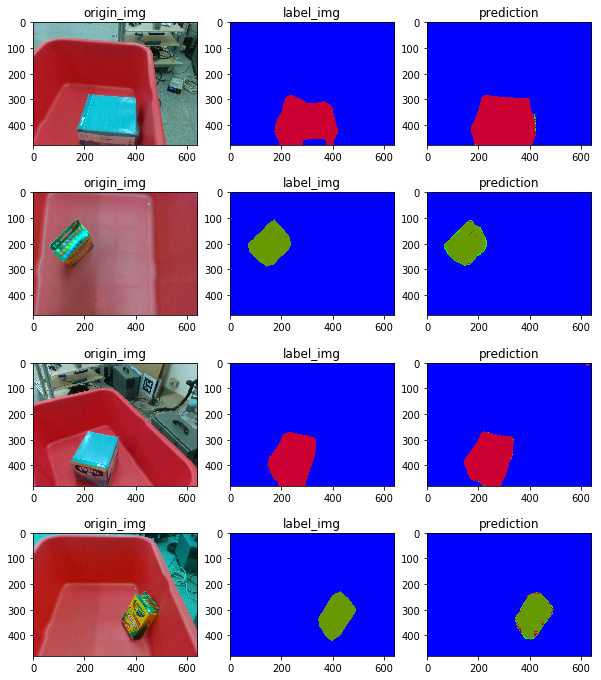

In [16]:
prediction("FCNs_products_20_batch10_epoch0_RMSprop_lr0.0001.pkl")